<a href="https://colab.research.google.com/github/HaidyTalaat/Reinforcement-Learning-Project-Maze-Solving-Self-Driving-Car/blob/Haidy-Rl-Maze-Project-Final-Docs/Best_Fine_Tuning_Model_for_DQN_Integrated_with_Env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Definition :**<br>
**Self-driving car that solves maze by finding shortest path and avoid obstacles that appears in the way.**


# **1. Importing Dependecies**

In [ ]:
!pip install pygame
!pip install tensorflow


In [1]:
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
import pygame
#from google.colab import files
from IPython.display import Image, display
import random
import time
import cv2
import glob
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# **2. Creating our environment**

In [ ]:
class CustomMazeEnv(Env):
    def __init__(self, render_mode="rgb_array", record_video=False, output_video_path="agent_demo.mp4",max_steps=500):
        super().__init__()
        self.total_reward = 0  # Initialize cumulative reward
        self.max_steps = max_steps
        self.current_steps = 0

        # 0 --> path 1 --> walls 2--> obstacles 3 --> agent 4 --> goal
        self.maze = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 3, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
            [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 4],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
            [1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ])

        # Locate starting and goal positions and set the agent at the start.
        self.start_pos = np.argwhere(self.maze == 3)[0]
        self.goal_pos = np.argwhere(self.maze == 4)[0]
        self.agent_pos = self.start_pos.copy()

        self.action_space = Discrete(4)  # Up, Down, Left, Right
        self.observation_space = Box(low=np.array([0, 0]), high=np.array([14, 13]), dtype=np.int32)

        # Pygame Rendering
        pygame.init()
        pygame.font.init()
        self.font = pygame.font.SysFont(None, 30)  # You can change the size

        self.cell_size = 40
        self.screen = pygame.display.set_mode((self.maze.shape[1] * self.cell_size, self.maze.shape[0] * self.cell_size))
        pygame.display.set_caption("Custom Maze Environment")

        # sets up video recording if enabled.
        self.record_video = record_video
        if self.record_video:
            self.frame_rate = 25
            self.output_video_path = output_video_path
            self.fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            # Creates an OpenCV video writer object.
            self.out = cv2.VideoWriter(self.output_video_path, self.fourcc, self.frame_rate,
                                       (self.maze.shape[1] * self.cell_size, self.maze.shape[0] * self.cell_size))

    # Reset function
    def reset(self):
        self.agent_pos = self.start_pos.copy()
        self.total_reward = 0
        self.current_steps = 0
        self.current_reward = 0

        return np.array(self.agent_pos, dtype=np.int32)

    # Check Obstacle Avoidance
    def _avoided_obstacle(self, old_pos, new_pos):
        x, y = old_pos
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            if (x + dx, y + dy) != new_pos and self.maze[x + dx, y + dy] == 2:
                return True
        return False

    # Step Function
    def step(self, action):
        x, y = self.agent_pos
        old_pos = (x, y)  # Get current position

        # Navigation based on action
        if action == 0:
            new_x, new_y = x - 1, y  # up
        elif action == 1:
            new_x, new_y = x + 1, y  # down
        elif action == 2:
            new_x, new_y = x, y - 1  # left
        elif action == 3:
            new_x, new_y = x, y + 1  # right

        done = False
        reward = 0
        expected_maze_value = self.maze[new_x, new_y]

        self.current_steps += 1
        # Check for walls or obstacles
        if expected_maze_value == 1:  # Wall
            reward = -3
        elif expected_maze_value == 2:  # Obstacle
            reward = -5

        else:
            self.agent_pos = [new_x, new_y]
            if (new_x, new_y) == tuple(self.goal_pos):
                reward = 300
                done = True
            elif self._avoided_obstacle(old_pos, (new_x, new_y)):  # Reward for avoiding obstacles
                reward = 3
            else:
                # encourage faster goal reaching
                reward = -0.2

            # Reward for progress towards the goal
            goal_distance_before = np.abs(self.agent_pos - self.goal_pos).sum()
            goal_distance_after = np.abs(np.array([new_x, new_y]) - self.goal_pos).sum()
            if goal_distance_after < goal_distance_before:
                reward += 1  #

        self.total_reward += reward
        self.current_reward = self.total_reward  # Update reward for rendering
        if self.current_steps >= self.max_steps:  # End episode if steps exceed max
             done = True
        return np.array(self.agent_pos, dtype=np.int32), reward, done, expected_maze_value  # Return immediate reward

    # Render Function
    def render(self, save_as_image=False, image_path="maze_image.png"):
        self.screen.fill((255, 255, 255))
        colors = {
            1: (0, 0, 0),   # Walls (black)
            2: (255, 0, 0), # Obstacles (red)
            3: (0, 255, 0), # Agent (green)
            4: (0, 0, 255), # Goal (blue)
            0: (255, 255, 255) # Path (white)
        }

        # Draw maze
        for r in range(self.maze.shape[0]):
            for c in range(self.maze.shape[1]):
                pygame.draw.rect(
                    self.screen, colors[self.maze[r, c]],
                    (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size)
                )
                pygame.draw.rect(
                    self.screen, (0, 0, 0),
                    (c * self.cell_size, r * self.cell_size, self.cell_size, self.cell_size), 1
                )

        # Draw agent
        agent_x = self.agent_pos[1] * self.cell_size + self.cell_size // 2
        agent_y = self.agent_pos[0] * self.cell_size + self.cell_size // 2
        pygame.draw.circle(
            self.screen, (255, 255, 0),
            (agent_x, agent_y),
            self.cell_size // 3
        )

        # Draw info text
        lives_text = self.font.render(f"Step: {self.current_steps}/{self.max_steps}", True, (255, 0, 0))
        reward_text = self.font.render(f"Reward: {self.current_reward}", True, (255, 105, 180))

        self.screen.blit(lives_text, (self.maze.shape[1] * self.cell_size - 120, 10))
        self.screen.blit(reward_text, (10, 10))

        pygame.display.flip()

        # Video recording
        if self.record_video:
            frame = pygame.surfarray.array3d(self.screen)
            frame = np.transpose(frame, (1, 0, 2))
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            self.out.write(frame)

        if save_as_image:
            pygame.image.save(self.screen, image_path)
        return pygame.surfarray.array3d(self.screen).swapaxes(0, 1)

    def close(self):

        if self.record_video:
            self.out.release()
            print(f"Video saved to {self.output_video_path}")
        pygame.quit()


In [ ]:

env = CustomMazeEnv(record_video=True)

### 🎥 Random Agent Demo

[Watch the video](https://github.com/HaidyTalaat/Reinforcement-Learning-Project-Maze-Solving-Self-Driving-Car/blob/mariam-random-agent-recording-demo/Random_actions_demo%20.mp4)


# **3. Fine Tuning on Model Hyperparameters**

**3.1 Defining Hyperparameters**

In [ ]:
learning_rate_a = 0.0001
discount_factor_g = 0.9         # discount rate (gamma)
network_sync_rate = 200        # number of steps the agent takes before syncing the policy and target network
replay_memory_size = 5000       # size of replay memory
mini_batch_size = 32           # size of the training data set sampled from the replay memory
epsilon = 1.0                 # exploration rate
epsilon_decay = 0.957           # exploration rate decay
epsilon_min = 0.1  # Never fully stop exploring
episodes = 25

**3.2 Building Model**

In [ ]:
def build_model(state_size, action_size):
    model = Sequential()

    # First hidden layer with Leaky ReLU
    model.add(Dense(256, input_shape=(state_size,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Second hidden layer with Leaky ReLU
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())

    # Third hidden layer with Leaky ReLU
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(action_size, activation='linear'))

    return model

In [ ]:
states=env.observation_space.shape[0]
actions=env.action_space.n
states,actions

(2, 4)

In [ ]:
model = build_model(2, 4)
target_model = build_model(states, actions)
target_model.set_weights(model.get_weights())

model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate_a))
target_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate_a))


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,972 (171.77 KB)

 Trainable params: 43,076 (168.27 KB)

 Non-trainable params: 896 (3.50 KB)

**3.3 Experience Replay & Updating Memory**

In [ ]:
from collections import deque
max_size = replay_memory_size
memory = deque(maxlen=max_size)
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))


**3.4  Balance between exploration and exploitation**

In [ ]:
def epsilon_greedy_policy(q_values, epsilon, action_space):
    if np.random.rand() <= epsilon:
        return random.choice(range(action_space))
    else:
        return np.argmax(q_values)

**3.5 Training loop**

In [ ]:
# Initialize lists to track metrics
episode_losses = []
episode_rewards = []
episode_steps = []

# Initialize global step counter for target network sync
global_step = 0
best_score = -np.inf
max_steps = 500

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    step_count = 0
    done = False
    flag=False
    #Initialize episode_loss to track if no training happens
    episode_loss = None

    while not done:

        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        q_values = model(state_tensor, training=False)[0].numpy()
        action = epsilon_greedy_policy(q_values, epsilon, env.action_space.n)
        next_state, reward, done, _ = env.step(action)

        # Store experience
        store_experience(state, action, reward, next_state, done)

        # Update state and counters
        state = next_state
        total_reward += reward
        step_count += 1
        global_step += 1

        # --- Training ---
        if len(memory) >= mini_batch_size and global_step % 4 == 0:
            mini_batch = random.sample(memory, mini_batch_size)
            states_batch = []
            targets_batch = []

            for state_b, action_b, reward_b, next_state_b, done_b in mini_batch:

                current_q = model(tf.expand_dims(state_b, 0), training=False).numpy()[0]
                next_q = target_model(tf.expand_dims(next_state_b, 0), training=False).numpy()[0]

                if done_b:
                    current_q[action_b] = reward_b
                else:
                    current_q[action_b] = reward_b + discount_factor_g * np.max(next_q)

                states_batch.append(state_b)
                targets_batch.append(current_q)

            # Train model
            history = model.fit(
                np.array(states_batch),
                np.array(targets_batch),
                batch_size=mini_batch_size,
                verbose=0
            )
            episode_loss = history.history['loss'][0]

            # update best model
            efficiency = 1 - (step_count / max_steps)
            episode_score = total_reward * 0.7 + efficiency * 0.3 * 100 # Scale efficiency

            # Save best model
            if episode_score > best_score:
                best_score = episode_score
                model.save('best_composite_model.keras')
                flag=True


            # Sync target network using GLOBAL step
            if global_step % network_sync_rate == 0:
                target_model.set_weights(model.get_weights())

    # --- Episode End Processing ---
    # Handle episodes with no training
    if episode_loss is None:
        episode_loss = episode_losses[-1] if episode_losses else 0  # Carry forward last loss

    episode_losses.append(episode_loss)
    episode_rewards.append(total_reward)
    episode_steps.append(step_count)

    # Epsilon decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    print(f"Episode {episode+1}/{episodes} | Composite Score: {episode_score:.1f}| Reward: {total_reward:.1f} | Steps: {step_count} | Loss: {episode_loss:.4f} | ε: {epsilon:.3f}")
    if flag: print(f"model saved at Episode {episode+1}/{episodes}")

Episode 1/25 | Composite Score: -256.6| Reward: -427.6 | Steps: 500 | Loss: 2.0403 | ε: 0.957
model saved at Episode 1/25
Episode 2/25 | Composite Score: -286.8| Reward: -478.0 | Steps: 500 | Loss: 1.7588 | ε: 0.916
model saved at Episode 2/25
Episode 3/25 | Composite Score: -307.9| Reward: -513.2 | Steps: 500 | Loss: 2.1426 | ε: 0.876
Episode 4/25 | Composite Score: -103.9| Reward: 100.0 | Steps: 207 | Loss: 1.3621 | ε: 0.839
Episode 5/25 | Composite Score: 155.0| Reward: 220.0 | Steps: 117 | Loss: 1.5533 | ε: 0.803
model saved at Episode 5/25
Episode 6/25 | Composite Score: -107.3| Reward: 92.8 | Steps: 217 | Loss: 1.4544 | ε: 0.768
Episode 7/25 | Composite Score: -498.5| Reward: -834.0 | Steps: 500 | Loss: 1.3461 | ε: 0.735
Episode 8/25 | Composite Score: 41.6| Reward: 53.2 | Steps: 339 | Loss: 1.5096 | ε: 0.704
Episode 9/25 | Composite Score: -144.7| Reward: -241.2 | Steps: 500 | Loss: 1.9147 | ε: 0.673
Episode 10/25 | Composite Score: -127.0| Reward: 69.4 | Steps: 314 | Loss: 1.41

# **4. Showing Performanne across 25 Episodes**

**4.1 Rewards across episodes**

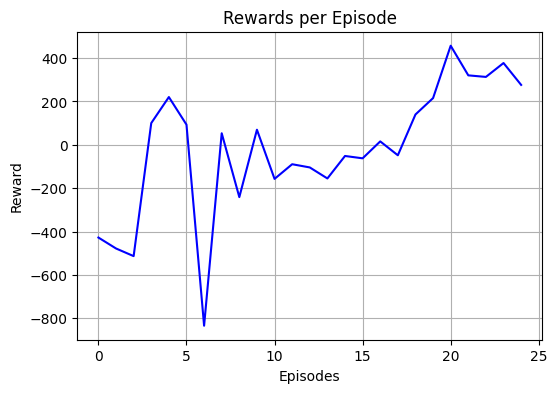

In [ ]:
# Plotting rewards per episode
plt.figure(figsize=(6, 4))
plt.plot(range(episodes), episode_rewards, color='blue', label='Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)
plt.show()


**The agent shows inconsistent performance, with rewards fluctuating between positive and negative values across episodes.**

**4.2 Steps across episodes**

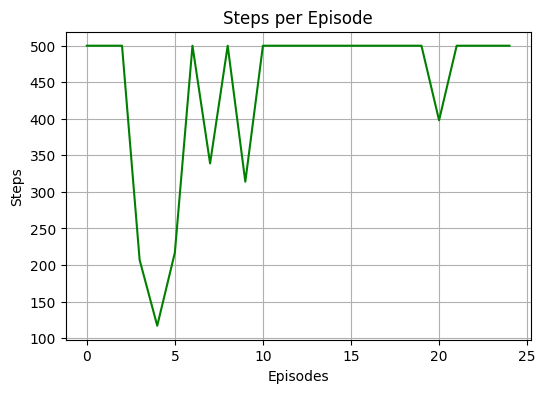

In [ ]:
# Plotting steps per episode
plt.figure(figsize=(6, 4))
plt.plot(range(episodes), episode_steps, color='green', label='Steps')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Steps per Episode')
plt.grid(True)
plt.show()


**all episodes took the maximum steps**

****4.3 Loss across episodes****

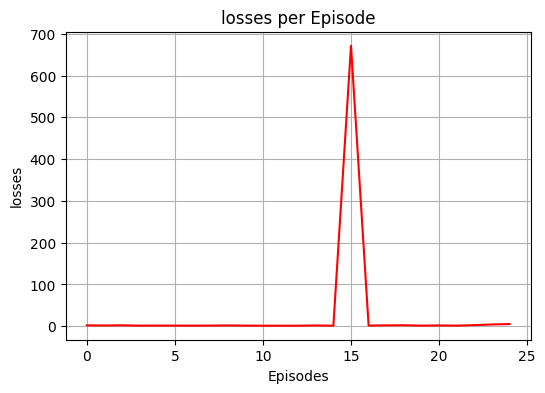

In [ ]:
# Plotting loss per episode
plt.figure(figsize=(6, 4))
plt.plot(range(episodes), episode_losses, color='red', label='Steps')
plt.xlabel('Episodes')
plt.ylabel('losses')
plt.title('losses per Episode')
plt.grid(True)
plt.show()


**AS we see there is extreme loss at episode 16**

# **5. Recording Demo Video for best saved model showing agent solves the maze**

In [ ]:
!pip install imageio imageio-ffmpeg


In [ ]:
env = CustomMazeEnv(record_video=True, output_video_path="final_agent_run.mp4", max_steps=500)


In [ ]:
import imageio
import numpy as np
from tqdm import trange
from tensorflow.keras.models import load_model

def demo(env, model_path, save_path="demo_video.mp4", episodes=1, epsilon=0.0):
    """
    Run a demo of the trained agent in the environment and save it as an MP4 video.

    Args:
        env: custom maze environment.
        model_path: path to the saved model (.h5).
        save_path: path to save the video (e.g., 'demo.mp4').
        episodes: number of episodes to record.
        epsilon: chance of taking a random action.
    """
    model = load_model(model_path)
    frames = []

    for ep in trange(episodes, desc="Generating demo"):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            frame = env.render()
            frames.append(frame)

            # Predict action
            q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(q_values)

            state, reward, done, _ = env.step(action)
            total_reward += reward

        print(f"Episode {ep + 1} Reward: {total_reward}")

    # Save as mp4 using imageio's ffmpeg plugin
    print("Saving video...")
    imageio.mimsave(save_path, frames, fps=10, codec='libx264')
    print(f"Video saved to {save_path}")


In [ ]:
env = CustomMazeEnv(record_video=True, output_video_path="agent_demo.mp4")

model = tf.keras.models.load_model('/kaggle/working/best_composite_model.keras')

# Record demo
demo(env, model_path='/kaggle/working/best_composite_model.keras', save_path="agent_run.mp4", epsilon=0.1)

Generating demo: 100%|██████████| 1/1 [00:33<00:00, 33.23s/it]

Episode 1 Reward: 588.8000000000003
Saving video...


Video saved to agent_run.mp4
